# Figure. Functional Annotation and POU5F1 Example

In [1]:
import cPickle
import glob
import os
import random
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import tabix
import vcf as pyvcf
import weblogolib as logo

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_functional_annotation_and_pou5f1_example'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [16]:
fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis', 'encode_dnase_res.tsv')
dnase_res = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis', 'encode_stem_cell_chip_seq_res.tsv')
tf_res = pd.read_table(fn, index_col=0)
tf_res = tf_res.drop_duplicates(subset=['target'])

fn = os.path.join(ciepy.root, 'output', 'fine_mapping', 'tf_disruption.tsv')
tf_disrupt = pd.read_table(fn, index_col=0)

In [3]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
sig = lead_vars[lead_vars.perm_sig]

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'gene_variant_pairs.tsv')
gene_variant_pairs = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls02', 'gene_variant_pairs.tsv')
gene_variant_pairs_secondary = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'fine_mapping', 'gene_variants_annotated.pickle')
gene_variant_pairs_annotated = pd.read_pickle(fn)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
motif_info = pd.read_table(fn, index_col=0)

In [5]:
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

fn = os.path.join(ciepy.root, 'private_output', 'eqtl_input', 
                  'filtered_all', '0000.vcf.gz')
vcf_reader = pyvcf.Reader(open(fn), compressed=True)
res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls01', 
                                 'gene_results', '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])

g = gene_info[gene_info.gene_name == 'POU5F1'].index[0]
res = ciepy.read_emmax_output(res_fns[g])
res = res.sort_values('PVALUE')
    
t =  vcf_reader.fetch(res.CHROM.values[0], 
                      res.BEG.values[0], 
                      res.BEG.values[0] + 1)
r = t.next()
tdf = pd.DataFrame(exp.ix[g])
tdf.columns = ['expression']
tdf['genotype'] = 0
hets = set(exp.columns) & set([s.sample for s in r.get_hets()])
tdf.ix[hets, 'genotype'] = 1
alts = set(exp.columns) & set([s.sample for s in r.get_hom_alts()])
tdf.ix[alts, 'genotype'] = 2
pou5f1_data = tdf
pou5f1_data.columns = ['Expression', 'Genotype']

In [6]:
fn = os.path.join(ciepy.root, 'output', 'fine_mapping', 'tf_disruption.tsv')
tf_disrupt = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'fine_mapping', 'motif_disruption.tsv')
motif_disrupt = pd.read_table(fn, index_col=0)

Let's see which TF's the significant variants for POU5F1 disrupt.

In [7]:
chrom = 'chr6'
start = 31110081
end = 31164667

In [8]:
tfd = gene_variant_pairs_annotated[gene_variant_pairs_annotated.gene_name == 'POU5F1']
tfd = tfd[tfd.tf_disrupt]
tfd.tss_dist

202479      58
202485   -1682
202510     328
Name: tss_dist, dtype: float64

In [9]:
tfd = gene_variant_pairs_annotated[gene_variant_pairs_annotated.gene_name == 'POU5F1']
tfd = tfd[tfd.tf_disrupt]
tfd = tfd[tfd.H1_roadmap_dnase]

In [10]:
tfd.location

202485    chr6:31140151-31140152
Name: location, dtype: object

In [11]:
tfd.tss_dist.abs()

202485    1682
Name: tss_dist, dtype: float64

In [12]:
tf_disrupt.ix['chr6:31138376-31138377'][tf_disrupt.ix['chr6:31138376-31138377']]

TATA    True
Name: chr6:31138376-31138377, dtype: bool

In [13]:
tfd = gene_variant_pairs_annotated[gene_variant_pairs_annotated.gene_name == 'POU5F1']
tfd = tfd[tfd.tf_disrupt]
#tfd = tfd[tfd.H1_roadmap_dnase]
tfd = tfd[(tfd.start > start) & (tfd.end < end)]
hstarts = list(set(tfd.start.values))
se = tfd[[x for x in tfd.columns if 'motif_disrupted' in x]].sum()
se = se[se == 1]
t = motif_disrupt.ix[tfd.location]
for i in t.index:
    se = t.ix[i]
    print('{}: {}'.format(i, ','.join(se[se].index)))

chr6:31138376-31138377: TATA_disc8
chr6:31140151-31140152: TATA_disc7
chr6:31138106-31138107: TATA_disc4


In [14]:
taf1_color = "#DB7093"
dnase_color = "#663399"

In [15]:
legend_colors = [
    np.array((255,0,0)) / 255.,
    np.array((255,105,105)) / 255.,
    np.array((250,202,0)) / 255.,
    np.array((255,252,4)) / 255.,
    np.array((10,190,254)) / 255.,
    np.array((0,176,80)) / 255.,
    np.array((0,176,80)) / 255.,
    np.array((153,255,102)) / 255.,
    np.array((245,245,245)) / 255.,
    ]
ind = [
    'Active promoter',
    'Weak promoter',
    'Strong enhancer',
    'Weak/poised enhancer',
    'Insulator',
    'Transcriptional transition',
    'Transcriptional elongation',
    'Weak transcribed',
    'Heterochromatin',
]
legend_colors = pd.Series(legend_colors, index=ind)

## Paper

In [17]:
tdf = dnase_res[dnase_res.biosample_type != 'immortalized cell line'].copy(deep=True)
a = tdf.shape[0]
b = tdf.cell_type.value_counts().shape[0]
print('{} samples from {} cell types.'.format(a, b))
print('{} skin fibroblasts.'.format(sum(tdf.cell_type == 'skin fibroblast')))

123 samples from 78 cell types.
9 skin fibroblasts.


In [ ]:
tdf.sort_values(by='pvalue', inplace=True)
np.where(tdf.cell_type == 'skin fibroblast')

In [19]:
tf_res.target_type.value_counts()

transcription factor                                                                                39
chromatin remodeller, transcription factor                                                           8
RNA binding protein, transcription factor                                                            3
broad histone mark, histone, histone modification                                                    2
chromatin remodeller, other context, other post-translational modification, transcription factor     1
histone, histone modification, narrow histone mark                                                   1
Name: target_type, dtype: int64

In [20]:
tf_res = tf_res[tf_res.target_type != 'histone, histone modification']

In [ ]:
tf_res.shape

In [ ]:
np.where(tf_res.target == 'POU5F1')

In [34]:
1.5 / 4.55

0.32967032967032966

In [33]:
2.75 + 0.25 * 6 + 0.05 * 6

4.55

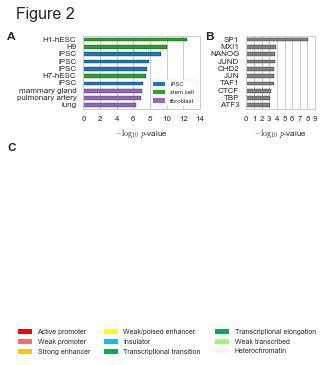

In [56]:
fig = plt.figure(figsize=(4.48, 5), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure 2',
        size=16, va='top')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.90, 0.5, 1])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = dnase_res[dnase_res.biosample_type != 'immortalized cell line']
t = dnase_res.ix[t.index].sort_values(by='pvalue', ascending=False).tail(10)
t.cell_type = t.cell_type.apply(lambda x: x.replace('induced pluripotent stem cell', 'iPSC'))
t.cell_type = t.cell_type.apply(lambda x: x.replace('fibroblast of ', ''))
# cdict = dict(zip(set(dnase_res.ix[t.index, 'biosample_type']), sns.color_palette('Set2')))
cdict = dict([['induced pluripotent stem cell line', cpb.analysis.tableau20[0]],
              ['stem cell', cpb.analysis.tableau20[4]],
              ['primary cell', cpb.analysis.tableau20[8]]])
#fig, ax = plt.subplots(1, 1, figsize=(5, 10))
c = [cdict[x] for x in dnase_res.ix[t.index, 'biosample_type']]
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color=c, label=None)
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=8)
#ax.set_title('ENCODE DNase enrichments')
ya, yb = ax.get_ylim()
ax.set_yticklabels(t.ix[t.index, 'cell_type'], fontsize=8)
rects = []
labels = []
for k in ['induced pluripotent stem cell line', 'stem cell',
          'primary cell',]:
    if k == 'induced pluripotent stem cell line':
        labels.append('iPSC')
    elif k == 'in vitro differentiated cells':
        labels.append('in vitro\ndifferentiated\ncell')
    elif k == 'primary cell':
        labels.append('fibroblast')
    else:
        labels.append(k)
    r = plt.Rectangle((0, 0), 0, 0, fc=cdict[k])
    rects.append(r)
lgd = ax.legend(rects, labels, loc='lower right', frameon=True, fontsize=6)
#bbox_to_anchor=[0.5, -0.05])#, prop={'size':8}), loc='upper center',
for p in lgd.get_patches():
    p.set_linewidth(0)
ax.grid(axis='y')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0.58, 0.65, 0.92])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = tf_res.sort_values(by='pvalue', ascending=False).tail(10)
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color='grey', zorder=2)
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=8)
ya, yb = ax.get_ylim()
t = ax.set_yticklabels(t.target, fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.grid(axis='y')
gs.tight_layout(fig, rect=[0.6, 0.58, 1, 0.92])

# POU5F1 legend
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ciepy.clean_axis(ax)
rects = []
labels = []
for k in legend_colors.index:
    labels.append(k)
    rects.append(plt.Rectangle((0, 0), 0, 0, fc=legend_colors[k]))
lgd = ax.legend(rects, labels, loc='center', prop={'size':7}, ncol=3)
for p in lgd.get_patches():
    p.set_linewidth(0)
gs.tight_layout(fig, rect=[0, 0, 1, 0.08])

t = fig.text(0.005, 0.88, 'A', weight='bold', 
             size=12)
t = fig.text(0.62, 0.88, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.57, 'C', weight='bold', 
             size=12)

plt.savefig(os.path.join(outdir, 'functional_annotation_pou5f1_skeleton.pdf'))

In [45]:
%%R

suppressPackageStartupMessages(library(Gviz))
suppressPackageStartupMessages(library(GenomicFeatures))

In [46]:
gene_id = gene_info[gene_info.gene_name == 'POU5F1'].index[0]

res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls01', 
                                 'gene_results', '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])
res = ciepy.read_emmax_output(res_fns[gene_id])
res = res.sort_values('BEG')
res = res.dropna(subset=['PVALUE'])

res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls02', 
                                 'gene_results', '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])
res2 = ciepy.read_emmax_output(res_fns[gene_id])
res2 = res2.sort_values('BEG')
res2 = res2.dropna(subset=['PVALUE'])

grange = res[['BEG']]
grange.columns = ['start']
grange['end'] = grange['start'] + 1
data = pd.DataFrame(-np.log10(res.PVALUE))
data = pd.DataFrame([-np.log10(res.PVALUE), -np.log10(res2.PVALUE), 
                     -np.log10(res.PVALUE), -np.log10(res2.PVALUE)],
                    index=['primary', 'secondary', 'primary_sig', 'secondary_sig']).T
t = gene_variant_pairs[gene_variant_pairs.gene_id == gene_id]
data.index = res.MARKER_ID
data.ix[t.marker_id, 'primary'] = np.nan
data.ix[set(data.index) - set(t.marker_id), 'primary_sig'] = np.nan
t = gene_variant_pairs_secondary[gene_variant_pairs_secondary.gene_id == gene_id]
data.ix[t.marker_id, 'secondary'] = np.nan
data.ix[set(data.index) - set(t.marker_id), 'secondary_sig'] = np.nan
# data['secondary'] = np.nan
# data['secondary_sig'] = np.nan
starts = res.BEG

chrom = 'chr6'
start = 31110081
end = 31164667
fontsize = 8

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
%%R -i data,grange,chrom,start,end,fontsize,starts,taf1_color,dnase_color,hstarts

ideoTrack <- IdeogramTrack(
    genome="hg19", 
    fontsize=fontsize, 
    fontsize.legend=fontsize,
    fontcolor='black', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1
)

gtrack <- GenomeAxisTrack(
    col="black", 
    cex=1, 
    fontsize=8, 
    col.id="black", 
    fontcolor="black", 
    fontface=1,
    fontface.group=1,
    lwd=1,
)

gr <- GRanges(
    seqnames="chr6", 
    ranges=IRanges(start=starts, width=rep(1, length(starts))),
    primary=data["primary"],
    psig=data["primary_sig"],
)

pvalTrack <- DataTrack(
    gr,
    groups=c("Not significant", "Significant"),
    genome="hg19", 
    type="p", 
    alpha=0.75, 
    lwd=8,
    name="-log10 p-value", 
    fontsize=8,
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=0.5, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    fontcolor.title="black",
    fontface.title=1, 
    alpha.title=1,
    cex.legend=1,
    fontcolor.legend="black",
    fontface.legend=1,
    fontsize.legend=8,
)

biomTrack <- BiomartGeneRegionTrack(
    genome="hg19", 
    chromosome=chrom, 
    start=start, 
    end=end,
    name="", 
    fontsize=fontsize,
    collapseTranscripts='meta',
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black', 
    fontcolor.legend="black",
    background.title='transparent', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1, 
    geneSymbols=TRUE,
    cex.group=1,
    fontcolor.group="black",
    fontface.group=1,
    fontface.title=1, 
    alpha.title=1,
    lwd=0.8,
)

hmmTrack <- UcscTrack(
    track="Broad ChromHMM", 
    table="wgEncodeBroadHmmH1hescHMM",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=7,
    name="chromHMM",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

feat <- unique(feature(hmmTrack))
featCol <- setNames(as.list(rgb(t(sapply(strsplit(feat, ","),
as.numeric)), maxColorValue=255)), feat)
displayPars(hmmTrack) <- featCol

taf1Track <- UcscTrack(
    track="Uniform TFBS", 
    table="wgEncodeAwgTfbsHaibH1hescTaf1V0416102UniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=7,
    name="TAF1",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

dnaseTrack <- UcscTrack(
    track="Uniform DNaseI HS", 
    table="wgEncodeAwgDnaseUwdukeH1hescUniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=7,
    name="DHS",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

hgr <- GRanges(
    seqnames="chr6", 
    ranges=IRanges(start=hstarts, width=rep(1, length(hstarts))),
    )

pvalHT <- HighlightTrack(
    trackList=pvalTrack, 
    range=hgr,
    alpha=0.5,
    fill=NA)

taf1Track = setPar(taf1Track, "fill", taf1_color)
dnaseTrack = setPar(dnaseTrack, "fill", dnase_color)

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Note that the behaviour of the 'setPar' method has changed. You need to reassign the result to an object for the side effects to happen. Pass-by-reference semantic is no longer supported.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [48]:
%%R

taf1Track <- UcscTrack(
    track="Uniform TFBS", 
    table="wgEncodeAwgTfbsHaibH1hescTaf1V0416102UniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=7,
    name="TAF1",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

In [49]:
%%R

hgr <- GRanges(
    seqnames="chr6", 
    ranges=IRanges(start=hstarts, width=rep(1, length(hstarts))),
    )

pvalHT <- HighlightTrack(
    trackList=pvalTrack, 
    range=hgr,
    alpha=0.5,
    fill=NA)


In [50]:
fn = os.path.join(outdir, 'pou5f1.pdf')

In [51]:
%%R -i fn,start,end

pdf(fn, 4.48, 2.75)
plotTracks(c(gtrack, biomTrack, pvalHT, taf1Track,
             hmmTrack), chromosome="chr6", from=start, to=end, 
           col.title="black", sizes=c(1.5, 1.5, 5, 0.5, 0.5))
dev.off()

png 
  2 


TODO: Everything below needs to be updated, cleaned up, or removed.

In [ ]:
3 + 

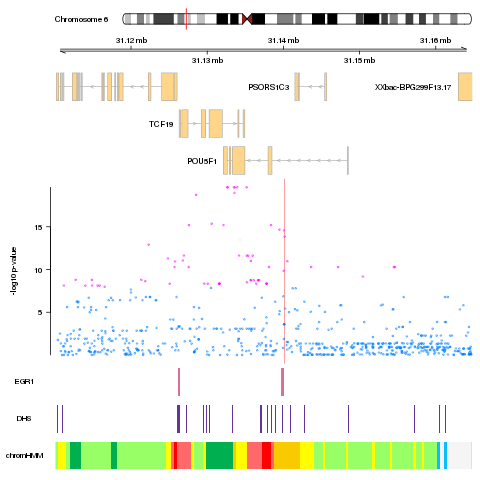

In [29]:
%%R -i start,end

plotTracks(c(ideoTrack, gtrack, biomTrack, pvalHT,
             egr1Track, dnaseTrack, hmmTrack), 
           chromosome="chr6", 
           from=start, to=end, col.title="black")

In [47]:
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'matrices.pickle')
with open(fn) as f:
    matrices = cPickle.load(f)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
motif_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_rep.tsv')
motif_info_rep = pd.read_table(fn, index_col=0)

In [48]:
def plot_tf_disruption(
    m,
    position, 
    ref, 
    alt, 
    genome_fasta,
    root,
    title=None,
):
    """ 
    Determine whether there is a difference between the ref and alt
    alleles for TF binding.
    
    Parameters
    ----------
    m : pd.DataFrame
        PWM as data frame. Columns are nucleotides.
    
    position : str
        Zero based genomic coordinates of the reference allele of the form
        chrom:start-end (chr5:100-101 for a SNV for instance). The value end -
        start should equal the length of the ref allele.

    ref : str
        Reference allele. This should match the reference sequence at "position"
        in genome_fasta.

    alt : str
        Alternate allele.

    genome_fasta : str
        Path to genome fasta file. This file should be indexed.
        
    rooot : str
        Path root to write images to.

    """
    import tempfile

    from Bio.Seq import Seq
    import MOODS
    max_motif_length = m.shape[0]
    chrom, coords = position.split(':')
    start,end = [int(x) for x in coords.split('-')]
    s = '{}\t{}\t{}\n'.format(chrom, start - max_motif_length + 1, end + max_motif_length - 1)
    f = tempfile.NamedTemporaryFile(mode='w', delete=False)
    f.write(s)
    f.close()
    with open(f.name) as f:
        seq_lines = [x.strip() for x in f.readlines()]
    c = 'bedtools getfasta -fi {} -bed {} -fo /dev/stdout'.format(genome_fasta,
                                                                  f.name)
    seq_lines = subprocess.check_output(c, shell=True).split()
    os.remove(f.name)
    ref_seq = seq_lines[1]
    alt_seq = ref_seq[0:max_motif_length - 1] + alt + ref_seq[max_motif_length + len(ref) - 1:]

    ref_variant_start = max_motif_length - 1
    ref_variant_end = max_motif_length - 1 + len(ref)
    alt_variant_start = max_motif_length - 1
    alt_variant_end = max_motif_length - 1 + len(alt)

    ms = [m.T.values.tolist()]
    ref_res = MOODS.search(ref_seq, ms, 0.001, both_strands=True,
                           bg=[0.25, 0.25, 0.25, 0.25])
    alt_res = MOODS.search(alt_seq, ms, 0.001, both_strands=True,
                           bg=[0.25, 0.25, 0.25, 0.25])
    starts = set([x[0] for x in ref_res[0]]) | set([x[0] for x in alt_res[0]])
    assert len(starts) == 1

    start = list(starts)[0]

    ref_seq = ref_seq[start:start + m.shape[0]]
    alt_seq = alt_seq[start:start + m.shape[0]]
    
    if start < 0:
        ref_seq = str(Seq(ref_seq).reverse_complement())
        alt_seq = str(Seq(alt_seq).reverse_complement())

    alphabet = logo.corebio.seq.unambiguous_dna_alphabet
    prior = [0.25, 0.25, 0.25, 0.25]
    counts = m.values
    assert counts.shape[1] == 4
    assert len(ref_seq) == len(alt_seq) == counts.shape[0]
    ref_counts = []
    for t in ref_seq:
        ref_counts.append([int(t.upper() == 'A'), int(t.upper() == 'C'),
                           int(t.upper() == 'G'), int(t.upper() == 'T')])
    alt_counts = []
    for t in alt_seq:
        alt_counts.append([int(t.upper() == 'A'), int(t.upper() == 'C'),
                           int(t.upper() == 'G'), int(t.upper() == 'T')])
    seq_counts = np.array(ref_counts) + np.array(alt_counts)
    #counts = np.concatenate([counts, seq_counts])
    #counts = np.concatenate([counts, ref_counts, alt_counts])
    data = logo.LogoData.from_counts(alphabet, counts, prior=None)
    fout = open(root + '_motif.png', 'w')
    options = logo.LogoOptions()
    options.fineprint = ''
    if title:
        options.logo_title = title
    else:
        options.logo_title = ''
    options.stacks_per_line = m.shape[0]
    options.show_xaxis = False
    options.show_yaxis = False
    options.color_scheme = logo.ColorScheme([logo.ColorGroup("G", "orange"), 
                                             logo.ColorGroup("C", "blue"),
                                             logo.ColorGroup("A", "green"),
                                             logo.ColorGroup("T", "red")])
    logo_format = logo.LogoFormat(data, options)
    fout.write(logo.png_print_formatter(data, logo_format))
    #fout.write(logo.pdf_formatter(data, logo_format))
    fout.close()
    
    data = logo.LogoData.from_counts(alphabet, seq_counts, prior=None)
    fout = open(root + '_sequence.png', 'w')
    options = logo.LogoOptions()
    options.fineprint = ''
    options.unit_name = 'probability'
    if title:
        options.logo_title = title
    else:
        options.logo_title = ''
    options.stacks_per_line = m.shape[0]
    options.show_xaxis = False
    options.show_yaxis = False
    options.color_scheme = logo.ColorScheme([logo.ColorGroup("G", "orange"), 
                                             logo.ColorGroup("C", "blue"),
                                             logo.ColorGroup("A", "green"),
                                             logo.ColorGroup("T", "red")])
    logo_format = logo.LogoFormat(data, options)
    fout.write(logo.png_print_formatter(data, logo_format))
    #fout.write(logo.pdf_formatter(data, logo_format))
    fout.close()

In [49]:
tfd.location

202485    chr6:31140151-31140152
Name: location, dtype: object

In [51]:
# chr6:31161228-31161229: RAD21_disc9
# chr6:31140151-31140152: TATA_disc7
# chr6:31140007-31140008: CHD2_disc3,EGR1_known3

# 420322    chr6:31161228-31161229
# 425471    chr6:31140151-31140152
# 425552    chr6:31140007-31140008

i = 202485
position = 'chr6:31140151-31140152'
m = matrices['TATA_disc7']
ref = tfd.ix[i, 'ref']
alt = tfd.ix[i, 'alt']
plot_tf_disruption(m, position, ref, alt, cpy.hg19, os.path.join(outdir, 'TATA'))

# i = 425552
# position = 'chr6:31140007-31140008'
# m = matrices['CHD2_disc3']
# ref = tfd.ix[i, 'ref']
# alt = tfd.ix[i, 'alt']
# c = plot_tf_disruption(m, position, ref, alt, cpy.hg19, os.path.join(outdir, 'CHD2'))

# i = 425552
# position = 'chr6:31140007-31140008'
# m = matrices['EGR1_known3']
# ref = tfd.ix[i, 'ref']
# alt = tfd.ix[i, 'alt']
# c = plot_tf_disruption(m, position, ref, alt, cpy.hg19, os.path.join(outdir, 'EGR1'))

# i = 425552
# position = 'chr6:31161228-31161229'
# m = matrices['RAD21_disc9']
# ref = tfd.ix[i, 'ref']
# alt = tfd.ix[i, 'alt']
# c = plot_tf_disruption(m, position, ref, alt, cpy.hg19, os.path.join(outdir, 'RAD21'))

In [ ]:
se = tfd[[x for x in tfd.columns if 'motif_disrupted' in x]].ix[0]
se[se]

In [72]:
se = tfd[[x for x in tfd.columns if 'motif_disrupted' in x]].ix[1]
se[se]

CHD2_disc3_motif_disrupted    True
Name: chr6:31140007-31140008:ENSG00000204531.11, dtype: object

In [73]:
position = 'chr6:31140151-31140152'
m = matrices['TATA_disc7']
ref = tfd.ix['chr6:31140151-31140152:ENSG00000204531.11', 'ref']
alt = tfd.ix['chr6:31140151-31140152:ENSG00000204531.11', 'alt']
plot_tf_disruption(m, position, ref, alt, cpy.hg19, os.path.join(outdir, 'TAF1'))

position = 'chr6:31140007-31140008'
m = matrices['CHD2_disc3']
ref = tfd.ix['chr6:31140007-31140008:ENSG00000204531.11', 'ref']
alt = tfd.ix['chr6:31140007-31140008:ENSG00000204531.11', 'alt']
c = plot_tf_disruption(m, position, ref, alt, cpy.hg19, os.path.join(outdir, 'CHD2'))

In [74]:
from IPython.display import Image 

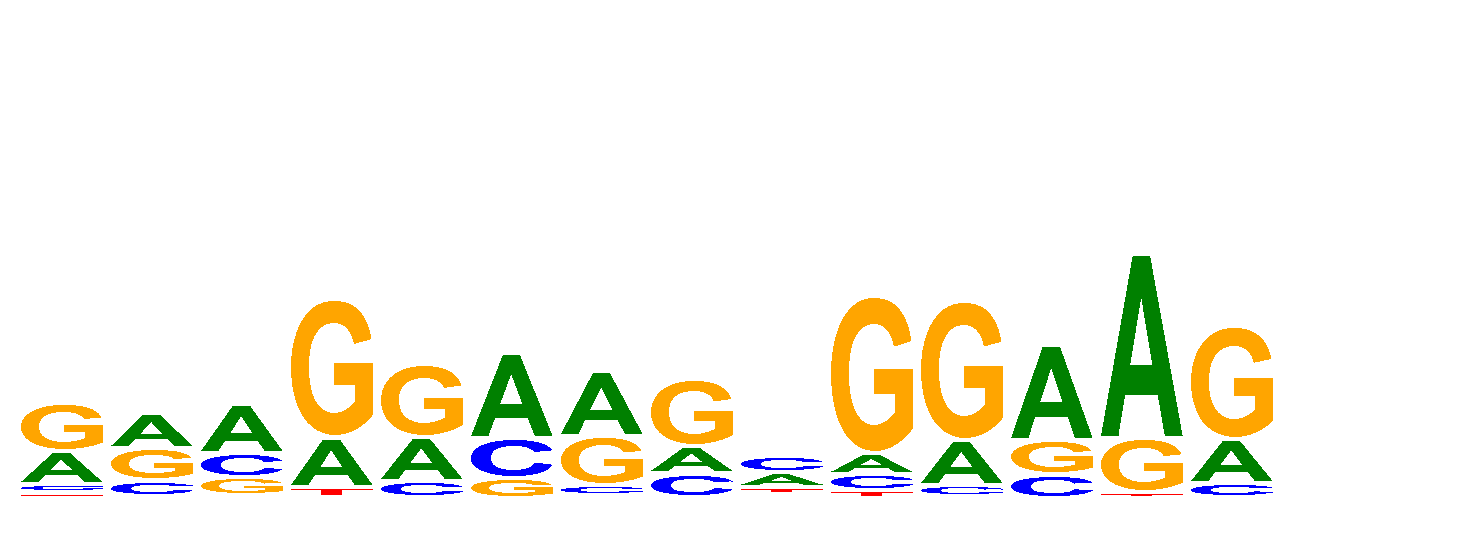

In [75]:
Image(filename=os.path.join(outdir, 'TAF1_motif.png'), width=200)

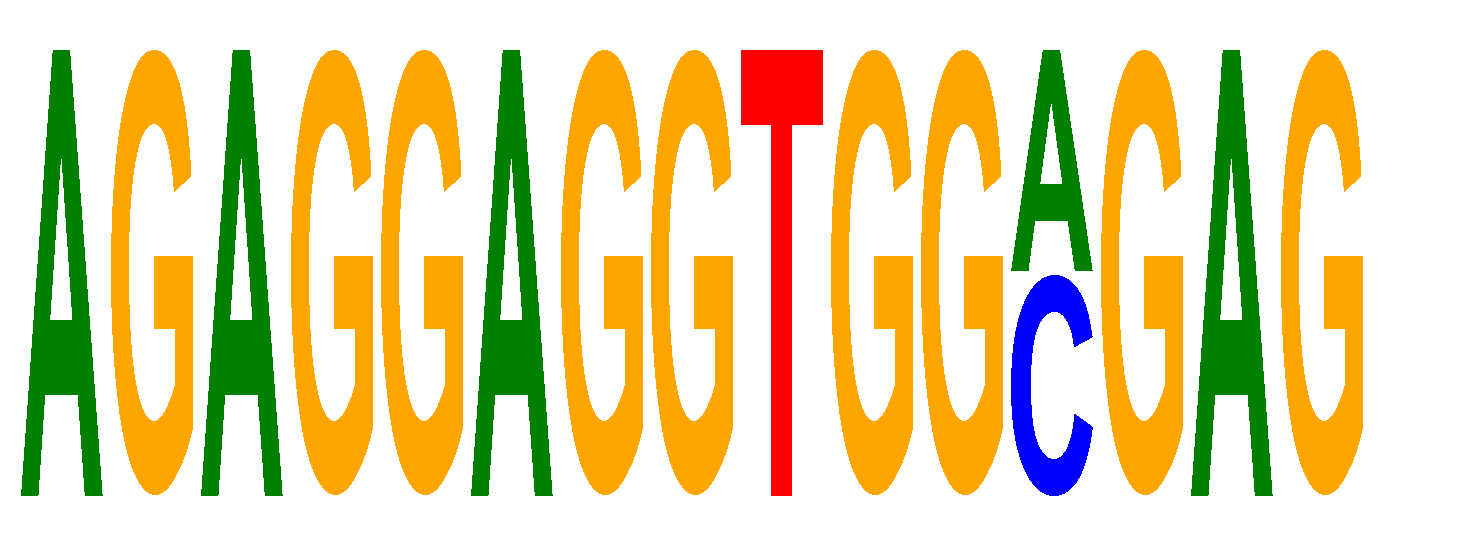

In [76]:
Image(filename=os.path.join(outdir, 'TAF1_sequence.png'), width=200)

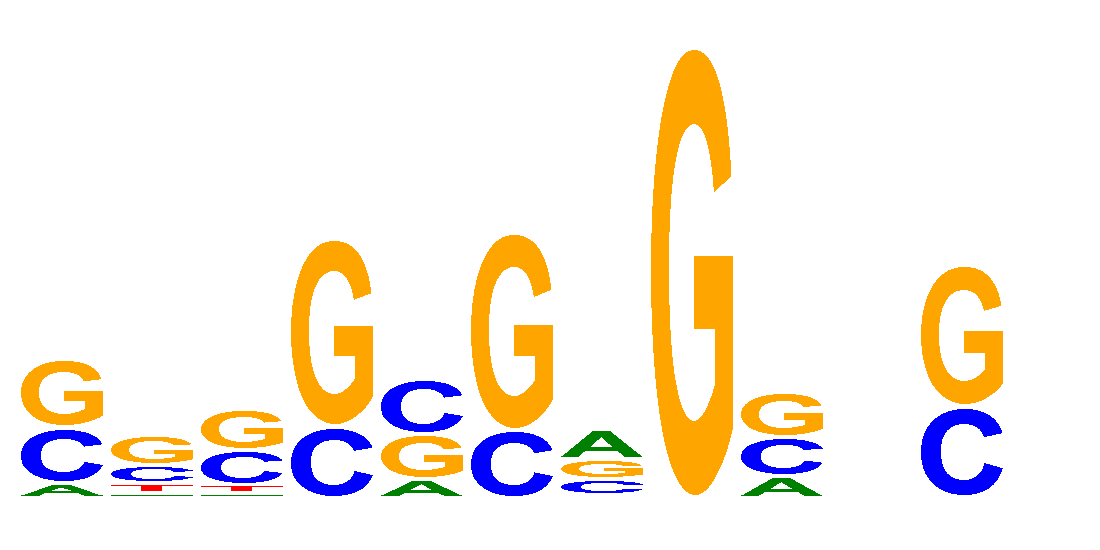

In [77]:
Image(filename=os.path.join(outdir, 'CHD2_motif.png'), width=200)

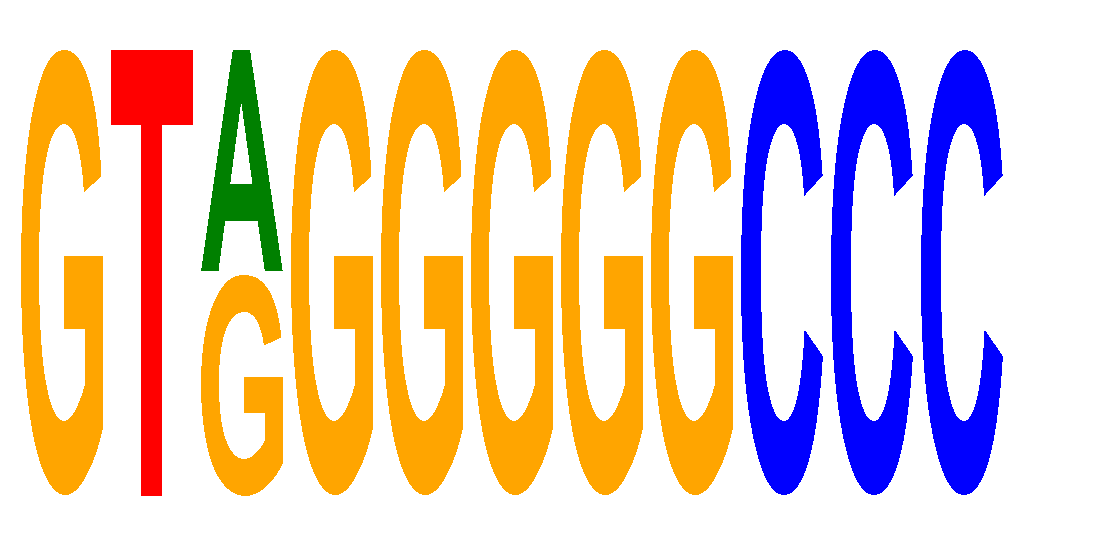

In [78]:
Image(filename=os.path.join(outdir, 'CHD2_sequence.png'), width=200)

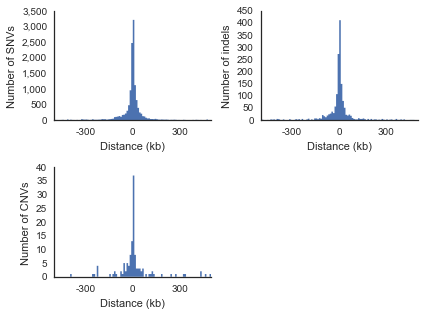

In [79]:
fig = plt.figure(figsize=(6, 4.5), dpi=300)

gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[0, 0])
n,b,p = ax.hist(sig[sig.variant_type == 'snv'].tss_dist, 
                bins=np.arange(-500000, 510000, 10000),
                histtype='stepfilled', linewidth=0)
ax.set_ylabel('Number of SNVs')
ticks = ax.set_xticks([-300000, 0, 300000])
ticks = ax.set_xticklabels([int(x) for x in ax.get_xticks() / 1000])
ax.set_xlim(-500000, 500000)
ax.set_xlabel('Distance (kb)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
    
ax = fig.add_subplot(gs[0, 1])
n,b,p = ax.hist(sig[(sig.variant_type == 'ins') | (sig.variant_type == 'del')].tss_dist, 
                bins=np.arange(-500000, 510000, 10000),
                histtype='stepfilled', linewidth=0)
ax.set_ylabel('Number of indels')
ticks = ax.set_xticks([-300000, 0, 300000])
ticks = ax.set_xticklabels([int(x) for x in ax.get_xticks() / 1000])
ax.set_xlim(-500000, 500000)
ax.set_xlabel('Distance (kb)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
    
ax = fig.add_subplot(gs[1, 0])
n,b,p = ax.hist(sig[sig.variant_type == 'cnv'].tss_dist, 
                bins=np.arange(-500000, 510000, 10000),
                histtype='stepfilled', linewidth=0)
ax.set_ylabel('Number of CNVs')
ticks = ax.set_xticks([-300000, 0, 300000])
ticks = ax.set_xticklabels([int(x) for x in ax.get_xticks() / 1000])
ax.set_xlim(-500000, 500000)
ax.set_xlabel('Distance (kb)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)

gs.tight_layout(fig)

fig.savefig(os.path.join(outdir, 'tss_hists.pdf'), transparent=True)

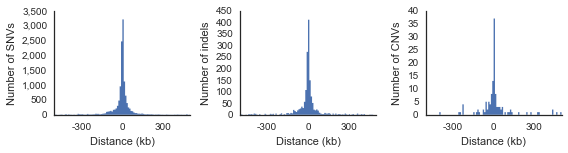

In [80]:
fig = plt.figure(figsize=(8, 2.25), dpi=300)

gs = gridspec.GridSpec(1, 3)
ax = fig.add_subplot(gs[0, 0])
n,b,p = ax.hist(sig[sig.variant_type == 'snv'].tss_dist, 
                bins=np.arange(-500000, 510000, 10000),
                histtype='stepfilled', linewidth=0)
ax.set_ylabel('Number of SNVs')
ticks = ax.set_xticks([-300000, 0, 300000])
ticks = ax.set_xticklabels([int(x) for x in ax.get_xticks() / 1000])
ax.set_xlim(-500000, 500000)
ax.set_xlabel('Distance (kb)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
    
ax = fig.add_subplot(gs[0, 1])
n,b,p = ax.hist(sig[(sig.variant_type == 'ins') | (sig.variant_type == 'del')].tss_dist, 
                bins=np.arange(-500000, 510000, 10000),
                histtype='stepfilled', linewidth=0)
ax.set_ylabel('Number of indels')
ticks = ax.set_xticks([-300000, 0, 300000])
ticks = ax.set_xticklabels([int(x) for x in ax.get_xticks() / 1000])
ax.set_xlim(-500000, 500000)
ax.set_xlabel('Distance (kb)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
    
ax = fig.add_subplot(gs[0, 2])
n,b,p = ax.hist(sig[sig.variant_type == 'cnv'].tss_dist, 
                bins=np.arange(-500000, 510000, 10000),
                histtype='stepfilled', linewidth=0)
ax.set_ylabel('Number of CNVs')
ticks = ax.set_xticks([-300000, 0, 300000])
ticks = ax.set_xticklabels([int(x) for x in ax.get_xticks() / 1000])
ax.set_xlim(-500000, 500000)
ax.set_xlabel('Distance (kb)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)

gs.tight_layout(fig)

fig.savefig(os.path.join(outdir, 'tss_hists_one_row.pdf'), transparent=True)

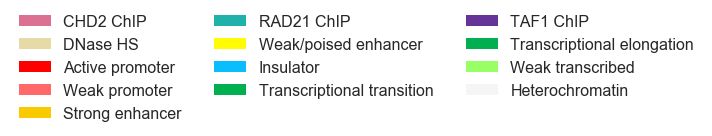

In [81]:
fig,ax = plt.subplots(1, 1, figsize=(10, 2), dpi=300)

ciepy.clean_axis(ax)
rects = []
labels = []
for k in legend_colors.index:
    labels.append(k)
    rects.append(plt.Rectangle((0, 0), 0, 0, fc=legend_colors[k]))
lgd = ax.legend(rects, labels, loc='center', ncol=3, prop={'size':16})
for p in lgd.get_patches():
    p.set_linewidth(0)

plt.tight_layout()
fig.savefig(os.path.join(outdir, 'ucsc_legend.pdf'), transparent=True)

In [90]:
gene_id = gene_info[gene_info.gene_name == 'POU5F1'].index[0]

res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls01', 
                                 'gene_results', '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])
res = ciepy.read_emmax_output(res_fns[gene_id])
res = res.sort_values('BEG')
res = res.dropna(subset=['PVALUE'])

res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls02', 
                                 'gene_results', '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])
res2 = ciepy.read_emmax_output(res_fns[gene_id])
res2 = res2.sort_values('BEG')
res2 = res2.dropna(subset=['PVALUE'])

grange = res[['BEG']]
grange.columns = ['start']
grange['end'] = grange['start'] + 1
data = pd.DataFrame(-np.log10(res.PVALUE))
data = pd.DataFrame([-np.log10(res.PVALUE), -np.log10(res2.PVALUE)],
                    index=['one', 'two']).T
starts = res.BEG

chrom = 'chr6'
start = 31122118
end = 31158508
start = 31110081
end = 31164667
start=31110081
end=31164667
fontsize = 8

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [91]:
fontsize=16

In [106]:
%%R -i data,grange,chrom,start,end,fontsize,starts,chd2_color,rad21_color,taf1_color,dnase_color,hstarts

ideoTrack <- IdeogramTrack(
    genome="hg19", 
    fontsize=fontsize, 
    fontsize.legend=fontsize,
    fontcolor='black', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1
)

gtrack <- GenomeAxisTrack(
    col="black", 
    cex=1, 
    fontsize=fontsize,
    col.id="black", 
    fontcolor="black", 
    fontface=1,
    fontface.group=1,
    lwd=1,
)

gr <- GRanges(
    seqnames="chr6", 
    ranges=IRanges(start=starts, width=rep(1, length(starts))),
    primary=data["one"],
    secondary=data["two"]
    )

pvalTrack <- DataTrack(
    gr,
    groups=c("Primary", "Secondary"),
    genome="hg19", 
    type="p", 
    alpha=0.75, 
    lwd=8,
    name="-log10 p-value", 
    fontsize=12,
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    fontcolor.title="black",
    fontface.title=1, 
    alpha.title=1,
    cex.legend=1,
    fontcolor.legend="black",
    fontface.legend=1,
    fontsize.legend=fontsize,
)

biomTrack <- BiomartGeneRegionTrack(
    genome="hg19", 
    chromosome=chrom, 
    start=start, 
    end=end,
    name="", 
    fontsize=fontsize,
    collapseTranscripts='meta',
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black', 
    fontcolor.legend="black",
    background.title='transparent', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1, 
    geneSymbols=TRUE,
    cex.group=1,
    fontcolor.group="black",
    fontface.group=1,
    fontface.title=1, 
    alpha.title=1,
    lwd=0.8,
)

hmmTrack <- UcscTrack(
    track="Broad ChromHMM", 
    table="wgEncodeBroadHmmH1hescHMM",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=12,
    name="",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

feat <- unique(feature(hmmTrack))
featCol <- setNames(as.list(rgb(t(sapply(strsplit(feat, ","),
as.numeric)), maxColorValue=255)), feat)
displayPars(hmmTrack) <- featCol

chd2Track <- UcscTrack(
    track="Uniform TFBS", 
    table="wgEncodeAwgTfbsSydhH1hescChd2IggrabUniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=fontsize,
    name="CHD2",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

taf1Track <- UcscTrack(
    track="Uniform TFBS", 
    table="wgEncodeAwgTfbsHaibH1hescTaf1V0416102UniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=fontsize,
    name="TAF1",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

rad21Track <- UcscTrack(
    track="Uniform TFBS", 
    table="wgEncodeAwgTfbsHaibH1hescRad21V0416102UniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=fontsize,
    name="RAD21",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

dnaseTrack <- UcscTrack(
    track="Uniform DNaseI HS", 
    table="wgEncodeAwgDnaseUwdukeH1hescUniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=fontsize,
    name="DHS",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

hgr <- GRanges(
    seqnames="chr6", 
    ranges=IRanges(start=hstarts, width=rep(1, length(hstarts))),
    )

pvalHT <- HighlightTrack(
    trackList=pvalTrack, 
    range=hgr,
    alpha=0.5,
    fill=NA)

chd2Track = setPar(chd2Track, "fill", chd2_color)
rad21Track = setPar(rad21Track, "fill", rad21_color)
taf1Track = setPar(taf1Track, "fill", taf1_color)
dnaseTrack = setPar(dnaseTrack, "fill", dnase_color)

In [107]:
fn = os.path.join(outdir, 'pou5f1_presentation.pdf')

In [108]:
%%R -i fn,start,end

pdf(fn, 10, 6.5)
plotTracks(c(gtrack, biomTrack, pvalHT, chd2Track, rad21Track, taf1Track, dnaseTrack, hmmTrack), chromosome="chr6", 
           from=start, to=end, col.title="black")
dev.off()

png 
  2 


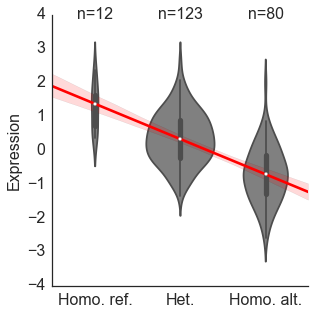

In [109]:
fig,ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
ax = sns.violinplot(x='Genotype', y='Expression', data=pou5f1_data, color='grey',
                    order=[0, 1, 2], scale='count')
sns.regplot(x='Genotype', y='Expression', data=pou5f1_data, scatter=False, color='red')
ya, yb = plt.ylim()
ax.set_xlabel('')
ax.set_xticklabels(['Homo. ref.', 'Het.', 'Homo. alt.'], fontsize=16)
plt.text(0, yb, 'n={}'.format(sum(tdf.Genotype == 0)), 
         verticalalignment='center', horizontalalignment='center', fontsize=16)
plt.text(1, yb, 'n={}'.format(sum(tdf.Genotype == 1)), 
         verticalalignment='center', horizontalalignment='center', fontsize=16)
plt.text(2, yb, 'n={}'.format(sum(tdf.Genotype == 2)), 
         verticalalignment='center', horizontalalignment='center', fontsize=16)
sns.despine(ax=ax)
for t in ax.get_yticklabels():
    t.set_fontsize(16)
ax.set_ylabel('Expression', fontsize=16)

plt.tight_layout()
fig.savefig(os.path.join(outdir, 'violin.pdf'), transparent=True)